# Tax
### This notebook will summarize my findings during EDA for taxation data and how tax data correlates with health outcomes.

## Income and Taxes Paid
The code below will estimate the correlation coefficient between adjusted gross income and the amount of tax paid.

In [31]:
import clickhouse_connect
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [32]:
client = clickhouse_connect.get_client(host='hub.publichealthhq.xyz', port=18123, username='default', password='Password123!')

In [36]:
result = client.query("""
SELECT (sum(ADJUSTED_GROSS_INCOME) / sum(NUM_RETURNS)) as agiavg, (sum(TAXES_PAID_AMOUNT) / sum(NUM_RETURNS)) as taxavg, any(STATE_NAME), any(COUNTY_NAME), MEASURE, avg(DATA_VALUE), median(DATA_VALUE) 
FROM cps_00004.places_county 
JOIN cps_00004.income_tax 
ON cps_00004.places_county.COUNTY_FIPS = cps_00004.income_tax.COUNTYFIP 
GROUP BY COUNTY_FIPS, MEASURE
ORDER BY agiavg DESC
""")
print(next(result.named_results()))
df = pl.from_dicts(result.named_results(), infer_schema_length=400)

{'agiavg': 248351.2928022362, 'taxavg': 7794.619147449336, 'any(STATE_NAME)': 'Wyoming', 'any(COUNTY_NAME)': 'Teton', 'MEASURE': 'Physical health not good for >=14 days among adults aged >=18 years', 'avg(DATA_VALUE)': 8.2, 'median(DATA_VALUE)': Decimal('8.2')}


In [16]:
s = [ (agi, tax) for (agi, tax) in zip(df['agiavg'], df['taxavg']) ]
obvs = np.asarray(s).transpose()
cc = np.corrcoef(obvs)
print(f'{cc[0][1]:1.4f}')

0.7691


The correlation coefficient is 0.769, which is a strong correlation. 

This dataset is also visualized below.

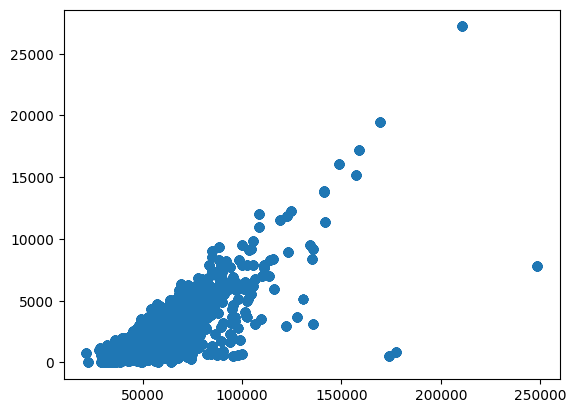

In [10]:
plt.scatter(df['agiavg'], df['taxavg'])
plt.show()

The correlation is most likely not closer to 1.0 for two reasons:

1. Tax filers in the lowest income brackets should be pushed down to have an effective tax rate of 0% because of deductions/the standard deduction.
2. Filers that have income from sources other than wages may be subject to a different tax rate

# Income and Health Outcomes
The plots below compare health outcomes in each county (in proportion to the county reporting the highest rate of that health outcome) and income (AGI).
The correlation coefficient is also reported for each group.

Measure: ('Mammography use among women aged 50-74 years',)
Correlation Coefficient: 0.3856


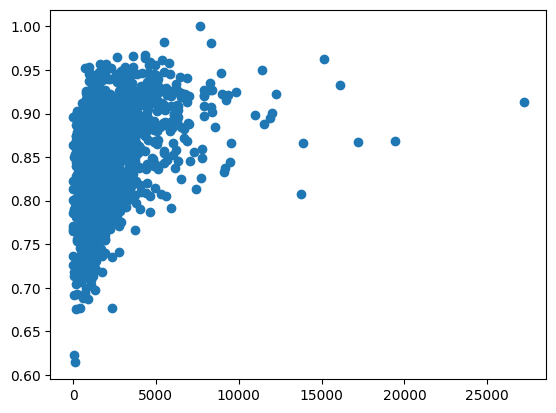

Measure: ('Depression among adults aged >=18 years',)
Correlation Coefficient: -0.2421


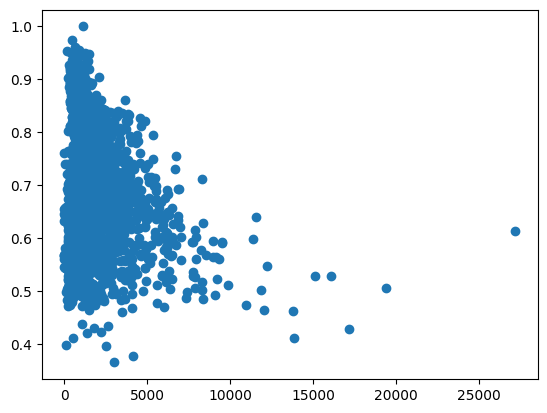

Measure: ('Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',)
Correlation Coefficient: 0.3267


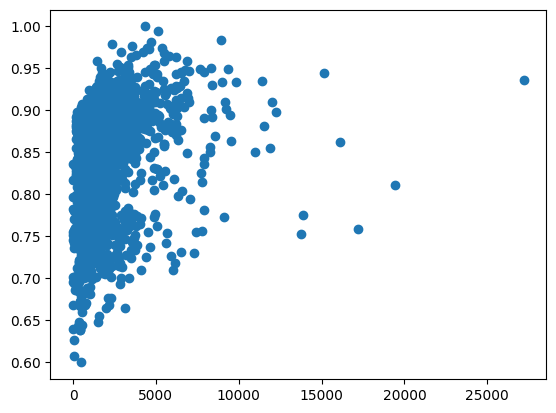

Measure: ('Independent living disability among adults aged >=18 years',)
Correlation Coefficient: -0.4924


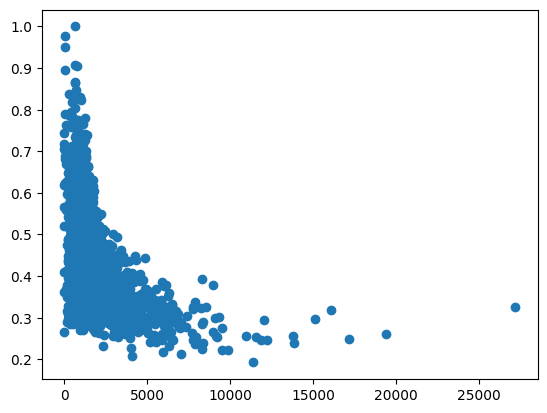

Measure: ('Self-care disability among adults aged >=18 years',)
Correlation Coefficient: -0.4760


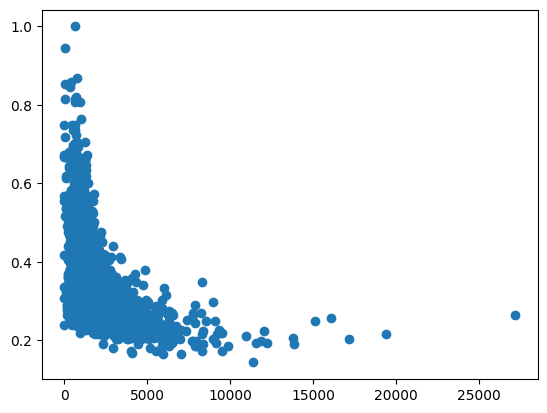

Measure: ('Visits to dentist or dental clinic among adults aged >=18 years',)
Correlation Coefficient: 0.5426


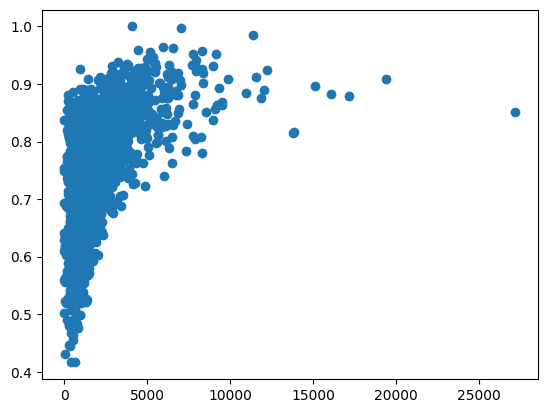

Measure: ('Sleeping less than 7 hours among adults aged >=18 years',)
Correlation Coefficient: -0.2756


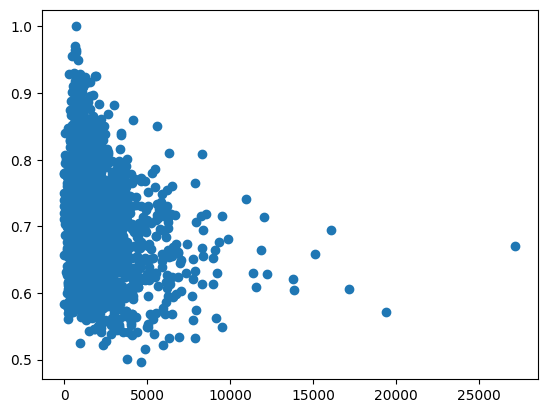

Measure: ('All teeth lost among adults aged >=65 years',)
Correlation Coefficient: -0.5313


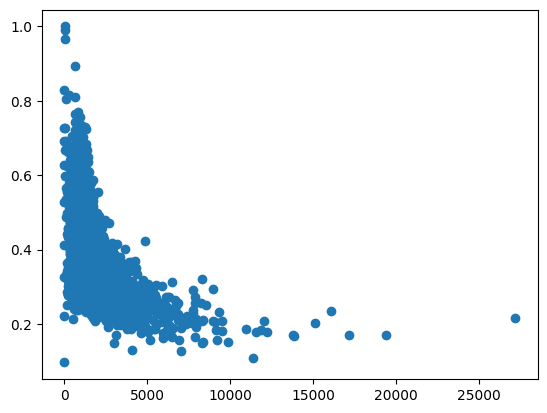

Measure: ('Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',)
Correlation Coefficient: 0.3340


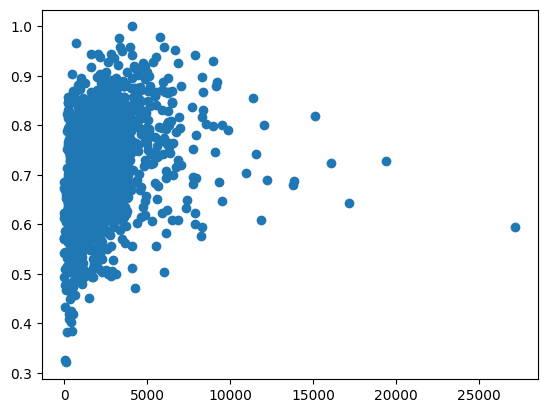

Measure: ('Mobility disability among adults aged >=18 years',)
Correlation Coefficient: -0.5116


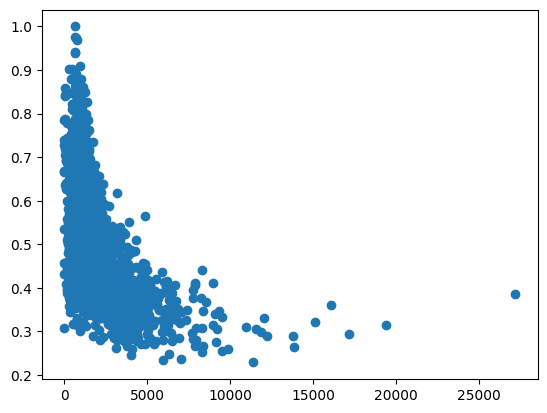

Measure: ('Cervical cancer screening among adult women aged 21-65 years',)
Correlation Coefficient: 0.4737


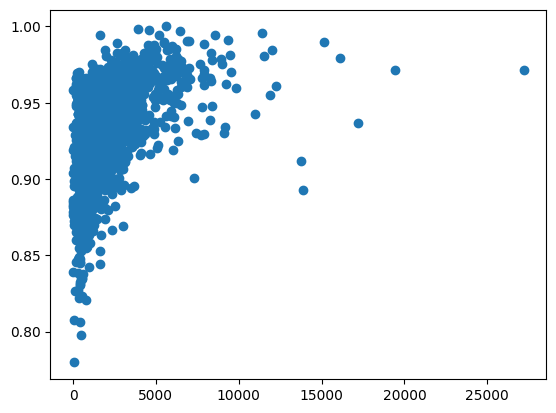

Measure: ('Fair or poor self-rated health status among adults aged >=18 years',)
Correlation Coefficient: -0.4946


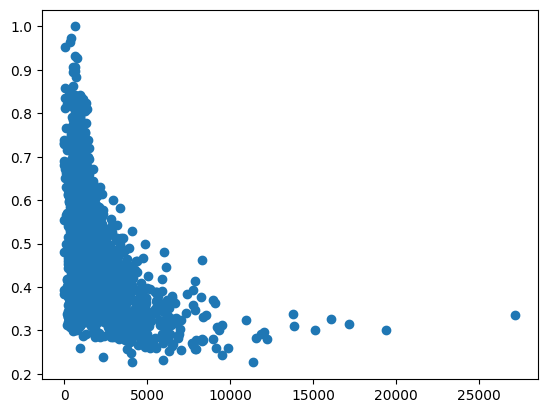

Measure: ('Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure',)
Correlation Coefficient: -0.2819


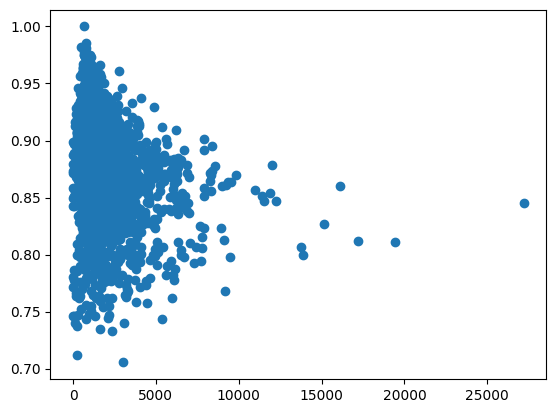

Measure: ('Cognitive disability among adults ages >=18 years',)
Correlation Coefficient: -0.4970


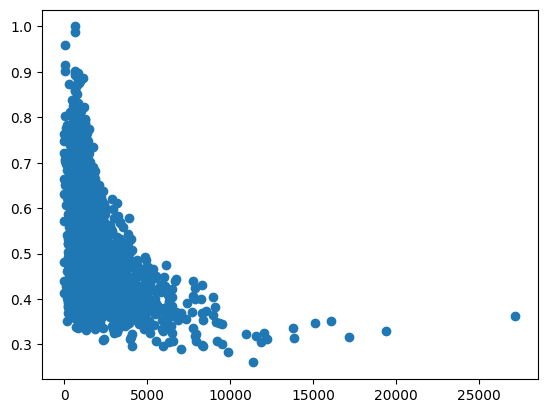

Measure: ('Coronary heart disease among adults aged >=18 years',)
Correlation Coefficient: -0.5794


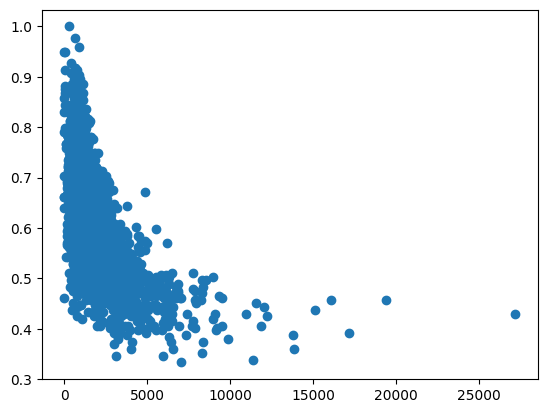

Measure: ('Stroke among adults aged >=18 years',)
Correlation Coefficient: -0.5101


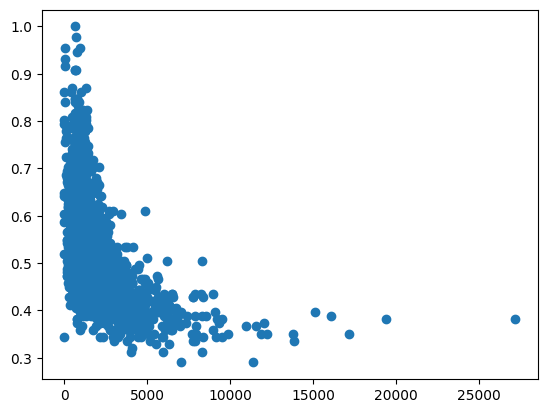

Measure: ('Cancer (excluding skin cancer) among adults aged >=18 years',)
Correlation Coefficient: -0.1426


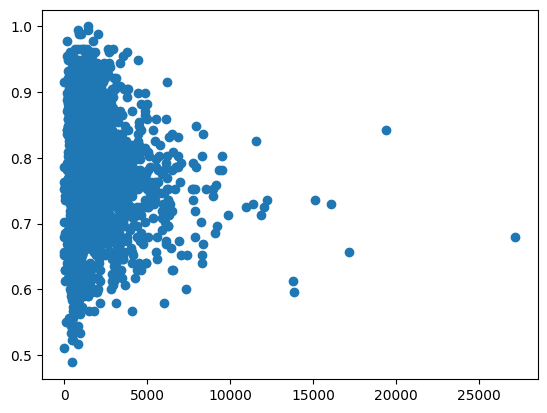

Measure: ('Hearing disability among adults aged >=18 years',)
Correlation Coefficient: -0.5575


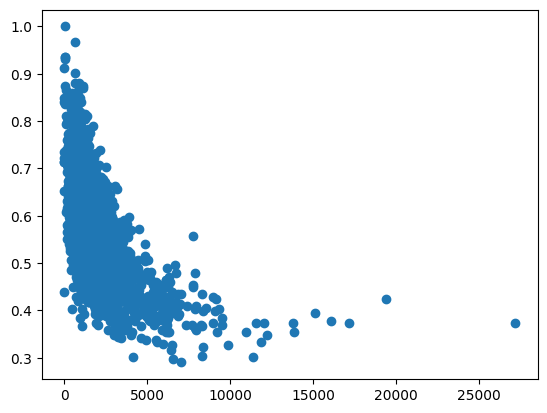

Measure: ('Chronic kidney disease among adults aged >=18 years',)
Correlation Coefficient: -0.4996


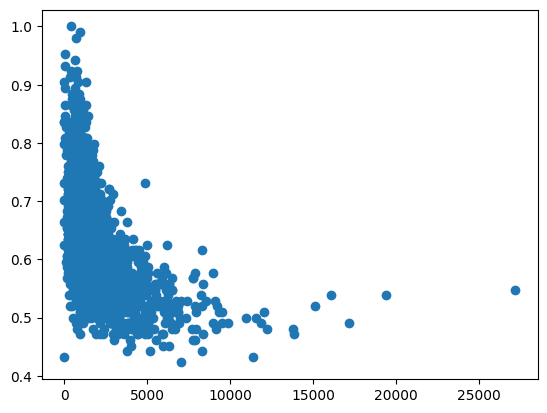

Measure: ('Obesity among adults aged >=18 years',)
Correlation Coefficient: -0.5398


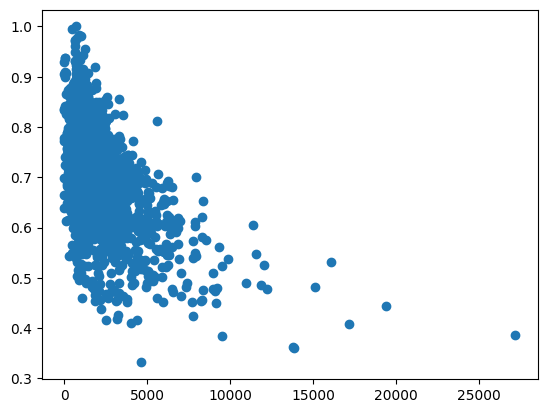

Measure: ('Visits to doctor for routine checkup within the past year among adults aged >=18 years',)
Correlation Coefficient: -0.0754


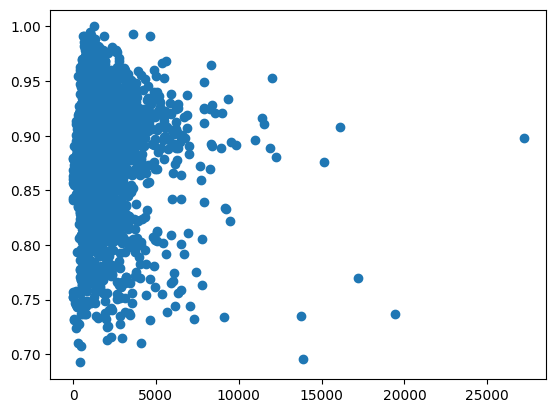

Measure: ('Cholesterol screening among adults aged >=18 years',)
Correlation Coefficient: 0.3262


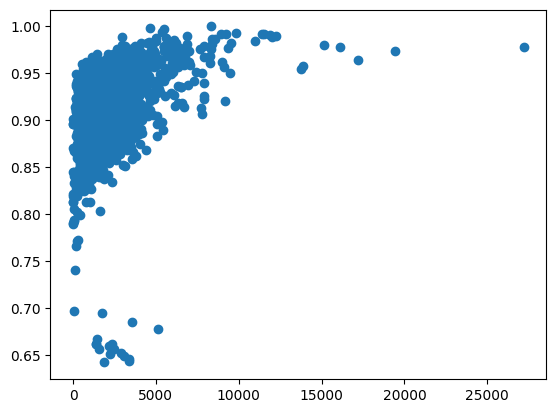

Measure: ('Vision disability among adults aged >=18 years',)
Correlation Coefficient: -0.4366


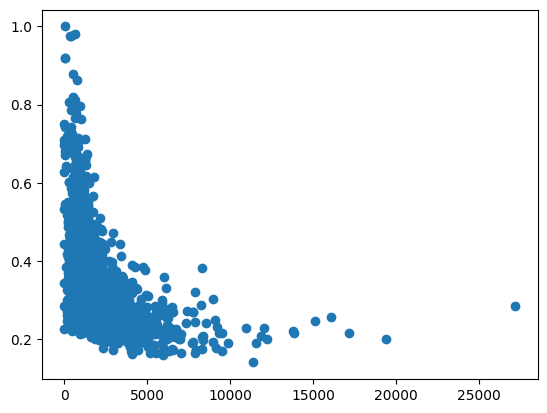

Measure: ('Arthritis among adults aged >=18 years',)
Correlation Coefficient: -0.4249


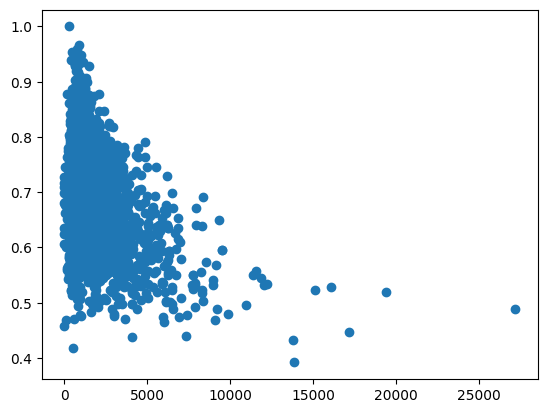

Measure: ('Any disability among adults aged >=18 years',)
Correlation Coefficient: -0.5457


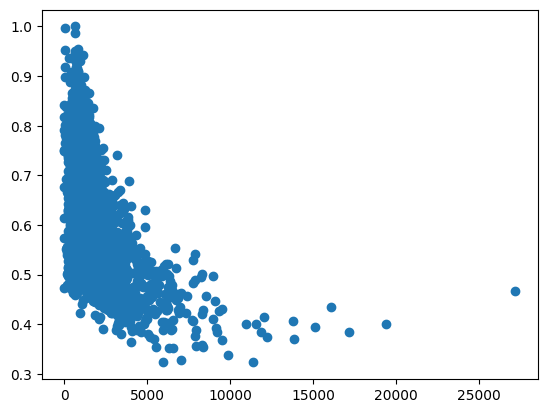

Measure: ('Binge drinking among adults aged >=18 years',)
Correlation Coefficient: 0.1781


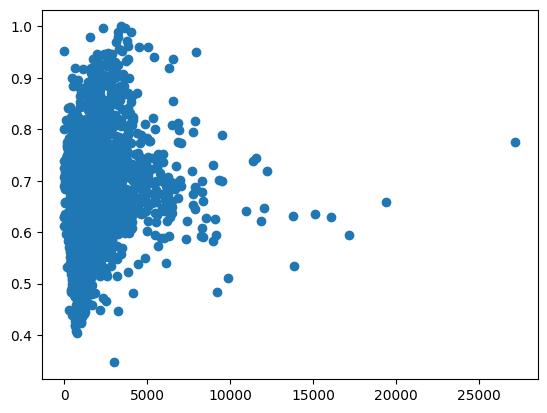

Measure: ('Diagnosed diabetes among adults aged >=18 years',)
Correlation Coefficient: -0.4550


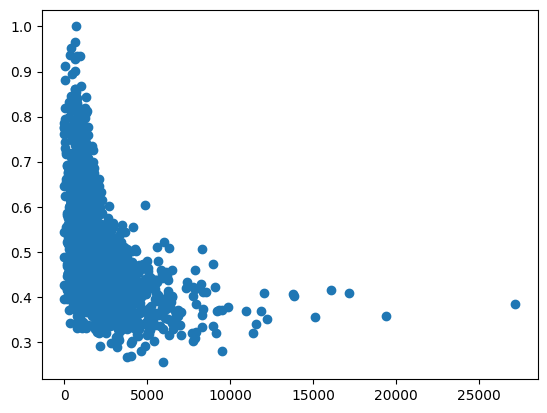

Measure: ('Physical health not good for >=14 days among adults aged >=18 years',)
Correlation Coefficient: -0.5344


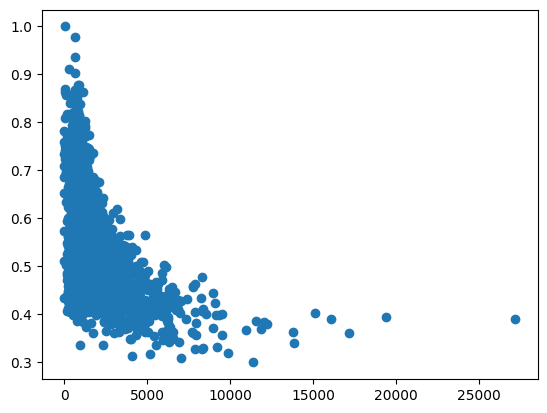

Measure: ('Current asthma among adults aged >=18 years',)
Correlation Coefficient: -0.2042


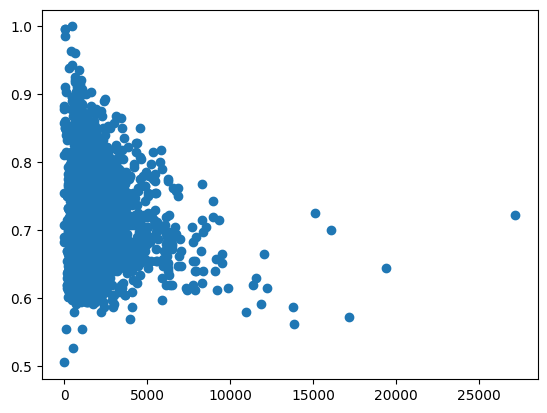

Measure: ('High cholesterol among adults aged >=18 years who have been screened in the past 5 years',)
Correlation Coefficient: -0.3336


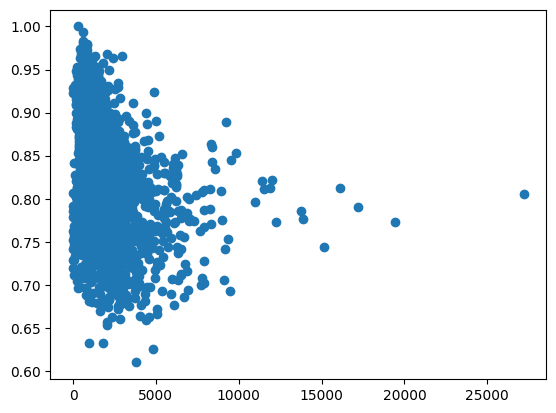

Measure: ('Current smoking among adults aged >=18 years',)
Correlation Coefficient: -0.5605


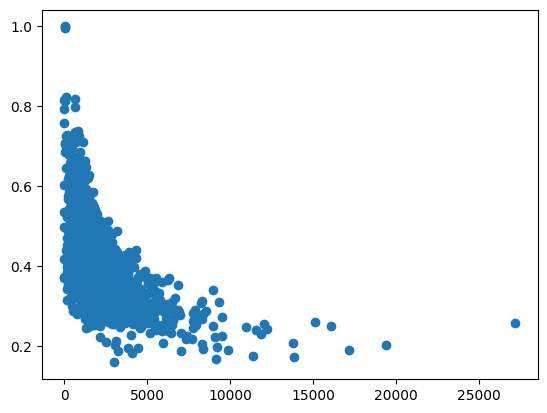

Measure: ('Current lack of health insurance among adults aged 18-64 years',)
Correlation Coefficient: -0.3633


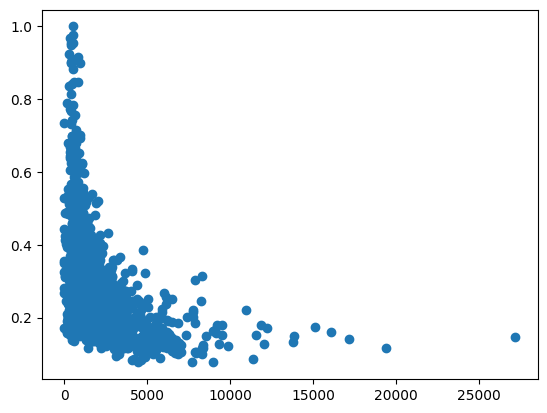

Measure: ('Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',)
Correlation Coefficient: 0.3873


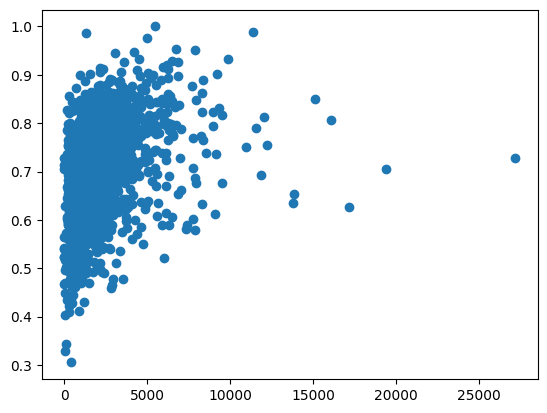

Measure: ('Chronic obstructive pulmonary disease among adults aged >=18 years',)
Correlation Coefficient: -0.5337


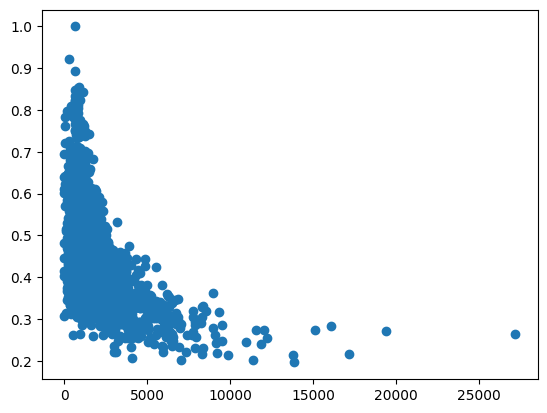

Measure: ('No leisure-time physical activity among adults aged >=18 years',)
Correlation Coefficient: -0.5395


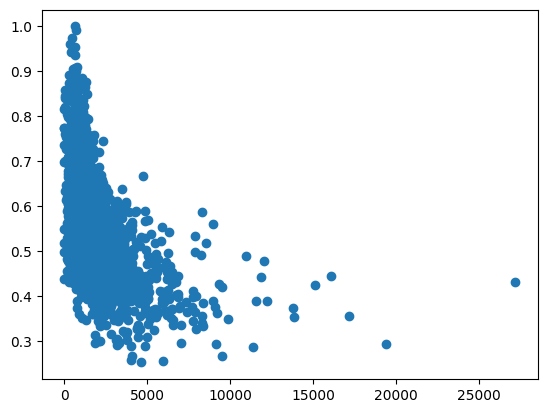

Measure: ('High blood pressure among adults aged >=18 years',)
Correlation Coefficient: -0.4607


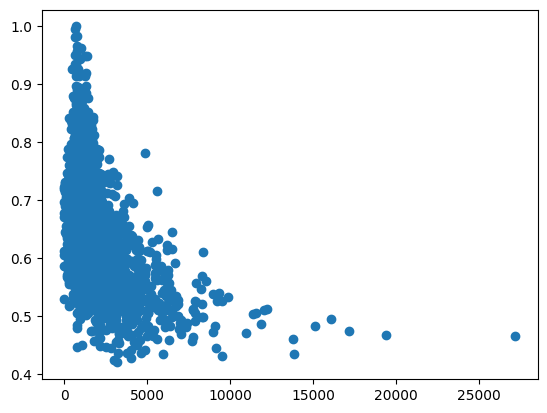

Measure: ('Mental health not good for >=14 days among adults aged >=18 years',)
Correlation Coefficient: -0.4311


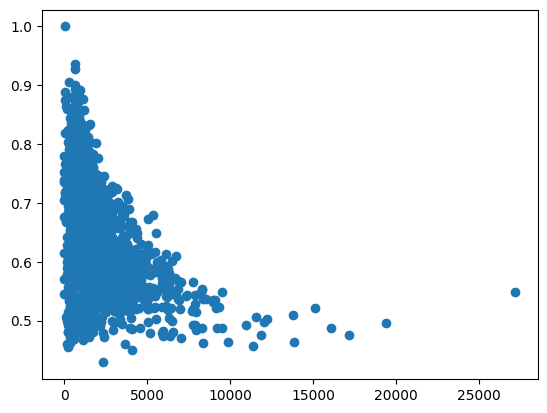

In [27]:
grouped = df.group_by(['MEASURE'])
core = []
for (group, frame) in grouped:
    max = frame['avg(DATA_VALUE)'].max()
    mean = frame['avg(DATA_VALUE)'].mean()
    print(f"Measure: {group}")
    s = [ (agi, affirmative) for (agi, affirmative) in zip(frame['taxavg'], frame['avg(DATA_VALUE)']) ]
    obvs = np.asarray(s).transpose()
    cc = np.corrcoef(obvs)
    print(f'Correlation Coefficient: {cc[0][1]:1.4f}')
    core.append( (group, cc[0][1]) )
    frame = frame.with_columns( (pl.col('avg(DATA_VALUE)') / max).alias('normalized_dv')) 
    plt.scatter(frame['taxavg'], frame['normalized_dv'])
    plt.show()

In [28]:
sorted(core, key=lambda k: abs(k[1]), reverse=True)

[(('Coronary heart disease among adults aged >=18 years',),
  -0.5793521160118683),
 (('Current smoking among adults aged >=18 years',), -0.5604711954919527),
 (('Hearing disability among adults aged >=18 years',), -0.5575104570552186),
 (('Any disability among adults aged >=18 years',), -0.5456575407666988),
 (('Visits to dentist or dental clinic among adults aged >=18 years',),
  0.5426132066340592),
 (('Obesity among adults aged >=18 years',), -0.5397946602642869),
 (('No leisure-time physical activity among adults aged >=18 years',),
  -0.5395273000482432),
 (('Physical health not good for >=14 days among adults aged >=18 years',),
  -0.5343610066695801),
 (('Chronic obstructive pulmonary disease among adults aged >=18 years',),
  -0.5336715196733686),
 (('All teeth lost among adults aged >=65 years',), -0.5313120594726191),
 (('Mobility disability among adults aged >=18 years',), -0.5115983716527686),
 (('Stroke among adults aged >=18 years',), -0.5101365553258073),
 (('Chronic ki